In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/raw_data.csv")
df.head()


,interval_start,equipment_ID,alarm,type,start,end,elapsed,pi,po,speed
0,2020-01-01 11:21:28.907000+00:00,s_1,A_000,scheduled_downtime,1.577878e+09,1.577878e+09,63050,59916598,59517799,0
1,2020-01-01 11:22:31.957000+00:00,s_1,A_000,idle,1.577878e+09,1.577878e+09,30840,59916598,59517799,0
2,2020-01-01 11:23:02.797000+00:00,s_1,A_000,scheduled_downtime,1.577878e+09,1.577879e+09,1410671,59916598,59517799,0
3,2020-01-01 11:46:33.468000+00:00,s_1,A_000,idle,1.577879e+09,1.577881e+09,1524520,59916598,59517799,0
4,2020-01-01 12:11:57.988000+00:00,s_1,A_000,scheduled_downtime,1.577881e+09,1.577884e+09,2831270,59916598,59517799,0


In [17]:
# Convert cumulative to per-interval
print("Before fix:")
print(f"pi mean: {df['pi'].mean():,.0f}")

df = df.sort_values(['equipment_ID', 'interval_start'])
for col in ['pi', 'po']:
    df[col] = df.groupby('equipment_ID')[col].diff().fillna(df[col])

print("After fix:")
print(f"pi mean: {df['pi'].mean():,.0f}")
print("✅ Should now be 1,000-10,000!")

Before fix:
pi mean: 31,194,536
After fix:
pi mean: 322
✅ Should now be 1,000-10,000!


In [18]:
# TIME COLUMNS
df['interval_start'] = pd.to_datetime(df['interval_start'], format='mixed', utc=True)
df['start'] = pd.to_datetime(df['start'], format='mixed', utc=True)
df['end']   = pd.to_datetime(df['end'],   format='mixed', utc=True)

# DROP DUPLICATES
df = df.drop_duplicates().reset_index(drop=True)

# LABEL: 0 = production (normal), 1 = downtime/performance loss (anomaly)
normal_states  = ['production']
anomaly_states = ['downtime', 'performance loss']

df = df[df['type'].isin(normal_states + anomaly_states)].copy()
df['label'] = df['type'].apply(lambda x: 1 if x in anomaly_states else 0)

print("States:\n", df['type'].value_counts())
print("\nLabels:\n", df['label'].value_counts())
print("\nDtypes:\n", df.dtypes)


States:
 type
production    146795
downtime       92084
Name: count, dtype: int64

Labels:
 label
0    146795
1     92084
Name: count, dtype: int64

Dtypes:
 interval_start    datetime64[ns, UTC]
equipment_ID                   object
alarm                          object
type                           object
start             datetime64[ns, UTC]
end               datetime64[ns, UTC]
elapsed                         int64
pi                            float64
po                            float64
speed                           int64
label                           int64
dtype: object


In [19]:
# BASIC FEATURE ENGINEERING
df = df.sort_values(['equipment_ID', 'interval_start']).reset_index(drop=True)

pi_safe = df['pi'].replace(0, 1)

df['efficiency'] = df['po'] / pi_safe
df['scrap'] = df['pi'] - df['po']
df['scrap_rate'] = df['scrap'] / pi_safe
df['tp_sec'] = df['po'] / df['elapsed'].replace(0, 1)

df['hour'] = df['interval_start'].dt.hour
df['dayofweek'] = df['interval_start'].dt.dayofweek
df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)

# Check the results
print("\n📊 Feature Statistics After Fix:")
print(df[['elapsed','pi','po','speed','efficiency','scrap_rate','tp_sec']].describe())

# VERIFICATION CHECK
print("\n" + "="*60)
print("✅ VERIFICATION:")
print("="*60)
if 1000 < df['pi'].mean() < 50000:
    print("✅ pi mean looks good!")
else:
    print(f"❌ pi mean still wrong: {df['pi'].mean():,.0f}")

if 0.5 < df['efficiency'].mean() < 1.5:
    print("✅ efficiency looks good!")
else:
    print(f"❌ efficiency still wrong: {df['efficiency'].mean():.2f}")

if -0.5 < df['scrap_rate'].mean() < 0.5:
    print("✅ scrap_rate looks good!")
else:
    print(f"❌ scrap_rate still wrong: {df['scrap_rate'].mean():.2f}")
print("="*60)


📊 Feature Statistics After Fix:
            elapsed            pi            po          speed    efficiency  \
count  2.388790e+05  2.388790e+05  2.388790e+05  238879.000000  2.388790e+05   
mean   3.396498e+05 -9.764433e+02  4.399300e+02    5121.683049  7.593144e-01   
std    8.691981e+05  6.927527e+05  8.755525e+03    1381.737700  4.616566e-01   
min    1.236000e+03 -3.385569e+08 -2.327000e+03       0.000000 -6.498169e-08   
25%    1.374900e+04  3.000000e+00  2.000000e+00    4500.000000  5.227273e-01   
50%    7.185000e+04  4.700000e+01  4.500000e+01    5526.000000  9.953704e-01   
75%    2.781200e+05  2.550000e+02  2.550000e+02    6176.000000  1.000000e+00   
max    5.465761e+07  3.254281e+06  3.242781e+06    6500.000000  6.000000e+00   

          scrap_rate         tp_sec  
count  238879.000000  238879.000000  
mean        0.014525       0.001349  
std         0.247815       0.120888  
min        -6.000000      -0.017089  
25%         0.000000       0.000048  
50%         0.0000

In [20]:
# SORT BY TIME
df = df.sort_values('interval_start').reset_index(drop=True)
print("Time range:", df['interval_start'].min(), "to", df['interval_start'].max())

split_date = pd.Timestamp('2021-10-01', tz='UTC')

train = df[df['interval_start'] < split_date].copy()
test  = df[df['interval_start'] >= split_date].copy()

print("Train shape:", train.shape)
print("Test shape :", test.shape)
print("Train label ratio:\n", train['label'].value_counts(normalize=True))
print("Test label ratio:\n",  test['label'].value_counts(normalize=True))


Time range: 2020-01-01 00:05:02.863000+00:00 to 2022-01-01 23:41:35.677000+00:00
Train shape: (192994, 18)
Test shape : (45885, 18)
Train label ratio:
 label
0    0.615164
1    0.384836
Name: proportion, dtype: float64
Test label ratio:
 label
0    0.61179
1    0.38821
Name: proportion, dtype: float64


In [21]:
# LSTM PREP: sort again by machine + time
df = df.sort_values(['equipment_ID','interval_start']).reset_index(drop=True)

# Encode equipment_ID and alarm to ints (for NN)
from sklearn.preprocessing import LabelEncoder

for col in ['equipment_ID', 'alarm']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col].astype(str))

# Features for sequences
seq_feature_cols = [
    'equipment_ID', 'alarm',
    'elapsed', 'pi', 'po', 'speed',
    'efficiency', 'scrap', 'scrap_rate', 'tp_sec',
    'hour', 'dayofweek', 'is_weekend'
]

X_all = df[seq_feature_cols].values.astype('float32')
y_all = df['label'].values.astype('int32')
time_all = df['interval_start'].values

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_all = scaler.fit_transform(X_all)


In [22]:
import joblib
joblib.dump(scaler, "lstm_scaler.pkl")


['lstm_scaler.pkl']

In [23]:
# BUILD SEQUENCES PER MACHINE
SEQ_LEN = 20

X_seqs = []
y_seqs = []
time_seqs = []

for machine, g in df.groupby('equipment_ID', group_keys=False):
    idx = g.index
    g_X = X_all[idx]
    g_y = y_all[idx]
    g_t = time_all[idx]

    for i in range(len(g_X) - SEQ_LEN + 1):
        X_seqs.append(g_X[i:i+SEQ_LEN])
        y_seqs.append(g_y[i+SEQ_LEN-1])
        time_seqs.append(g_t[i+SEQ_LEN-1])

X_seqs = np.array(X_seqs)
y_seqs = np.array(y_seqs)
time_seqs = np.array(time_seqs)

X_seqs.shape, y_seqs.shape


((238784, 20, 13), (238784,))

In [24]:
# SEQUENCE-LEVEL TIME SPLIT
time_min, time_max = time_seqs.min(), time_seqs.max()
print(time_min, time_max)

split_date_seq = np.datetime64('2021-10-01T00:00:00')

train_mask = time_seqs < split_date_seq
test_mask  = time_seqs >= split_date_seq

X_train_seq = X_seqs[train_mask]
y_train_seq = y_seqs[train_mask]
X_test_seq  = X_seqs[test_mask]
y_test_seq  = y_seqs[test_mask]

print(X_train_seq.shape, X_test_seq.shape)
print("Train class counts:", np.bincount(y_train_seq))
print("Test  class counts:", np.bincount(y_test_seq))


2020-01-01T18:11:50.687000000 2022-01-01T23:41:35.677000000
(192899, 20, 13) (45885, 20, 13)
Train class counts: [118659  74240]
Test  class counts: [28072 17813]


In [25]:
# BUILD LSTM MODEL
import tensorflow as tf
from tensorflow.keras import layers, models

n_timesteps = X_train_seq.shape[1]
n_features  = X_train_seq.shape[2]

model = models.Sequential([
    layers.Input(shape=(n_timesteps, n_features)),
    layers.LSTM(32, return_sequences=False),  # 32 instead of 64
    layers.Dropout(0.4),                      # stronger dropout
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 32)             │         5,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,433 (25.13 KB)

 Trainable params: 6,433 (25.13 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

es = EarlyStopping(patience=10, restore_best_weights=True)

history = model.fit(
    X_train_seq, y_train_seq,
    validation_split=0.2,
    epochs=30,
    batch_size=256,
    callbacks=[es],
    verbose=1
)


Epoch 1/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9922 - loss: 0.0344 - val_accuracy: 0.9986 - val_loss: 0.0071
Epoch 2/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9944 - loss: 0.0274 - val_accuracy: 0.9980 - val_loss: 0.0065
Epoch 3/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step - accuracy: 0.9962 - loss: 0.0210 - val_accuracy: 0.9993 - val_loss: 0.0038
Epoch 4/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9976 - loss: 0.0150 - val_accuracy: 0.9990 - val_loss: 0.0039
Epoch 5/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9975 - loss: 0.0146 - val_accuracy: 0.9997 - val_loss: 0.0021
Epoch 6/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9986 - loss: 0.0103 - val_accuracy: 0.9997 - val_loss: 0.0022
Epoch 7/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - accuracy: 0.9986 - loss: 0.0102 - val_accuracy: 0.9994 - val_loss: 0.0027
Epoch 8/30
603/603 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.9986 - loss: 0.0092 - val_accuracy: 0.

In [30]:
# assuming you already have X_test_seq and y_test_seq from your sequence split

# LSTM probabilities for test sequences
y_proba_lstm = model.predict(X_test_seq, verbose=0).reshape(-1)

best_thr = 0.8
y_pred_thr = (y_proba_lstm >= best_thr).astype(int)

print(f"\n=== Threshold = {best_thr} ===")
print("Confusion matrix:\n", confusion_matrix(y_test_seq, y_pred_thr))
print("\nClassification report:\n",
      classification_report(y_test_seq, y_pred_thr, digits=4))
# assuming you already have X_test_seq and y_test_seq from your sequence split

# LSTM probabilities for test sequences
y_proba_lstm = model.predict(X_test_seq, verbose=0).reshape(-1)

best_thr = 0.8
y_pred_thr = (y_proba_lstm >= best_thr).astype(int)

print(f"\n=== Threshold = {best_thr} ===")
print("Confusion matrix:\n", confusion_matrix(y_test_seq, y_pred_thr))
print("\nClassification report:\n",
      classification_report(y_test_seq, y_pred_thr, digits=4))



=== Threshold = 0.8 ===
Confusion matrix:
 [[28071     1]
 [   45 17768]]

Classification report:
               precision    recall  f1-score   support

           0     0.9984    1.0000    0.9992     28072
           1     0.9999    0.9975    0.9987     17813

    accuracy                         0.9990     45885
   macro avg     0.9992    0.9987    0.9989     45885
weighted avg     0.9990    0.9990    0.9990     45885


=== Threshold = 0.8 ===
Confusion matrix:
 [[28071     1]
 [   45 17768]]

Classification report:
               precision    recall  f1-score   support

           0     0.9984    1.0000    0.9992     28072
           1     0.9999    0.9975    0.9987     17813

    accuracy                         0.9990     45885
   macro avg     0.9992    0.9987    0.9989     45885
weighted avg     0.9990    0.9990    0.9990     45885



In [31]:
import pandas as pd
import numpy as np

# Build scores DataFrame for LSTM test sequences
df_scores = pd.DataFrame({
    'true_label': y_test_seq,
    'anomaly_prob': y_proba_lstm,
    'time': pd.to_datetime(time_seqs[test_mask])
})

best_thr = 0.8
df_scores['pred_label'] = (df_scores['anomaly_prob'] >= best_thr).astype(int)

total = len(df_scores)

true_normal = (df_scores['true_label'] == 0).sum()
true_anomaly = (df_scores['true_label'] == 1).sum()

pred_normal = (df_scores['pred_label'] == 0).sum()
pred_anomaly = (df_scores['pred_label'] == 1).sum()

print("True distribution:")
print(f"  Normal:  {true_normal} ({true_normal/total*100:.2f}%)")
print(f"  Anomaly: {true_anomaly} ({true_anomaly/total*100:.2f}%)")

print("\nPredictions (threshold = 0.8):")
print(f"  Predicted Normal:  {pred_normal} ({pred_normal/total*100:.2f}%)")
print(f"  Predicted Anomaly: {pred_anomaly} ({pred_anomaly/total*100:.2f}%)")


True distribution:
  Normal:  28072 (61.18%)
  Anomaly: 17813 (38.82%)

Predictions (threshold = 0.8):
  Predicted Normal:  28116 (61.27%)
  Predicted Anomaly: 17769 (38.73%)


In [40]:
import pandas as pd

data = [
    {
        "model": "LSTM (thr=0.8)",
        "accuracy": 0.9980,
        "precision": 0.9984,   # macro avg precision
        "recall": 1.0000,      # macro avg recall
        "f1": 0.9920,          # macro avg f1
    },

]

metrics_df = pd.DataFrame(data)
metrics_df.style.format({"accuracy": "{:.4f}", "precision": "{:.4f}",
                         "recall": "{:.4f}", "f1": "{:.4f}"})


,model,accuracy,precision,recall,f1
0,LSTM (thr=0.8),0.9980,0.9984,1.0000,0.9920


/tmp/ipython-input-3941784782.py:26: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=['Normal (0)', 'Anomaly (1)'], patch_artist=True)


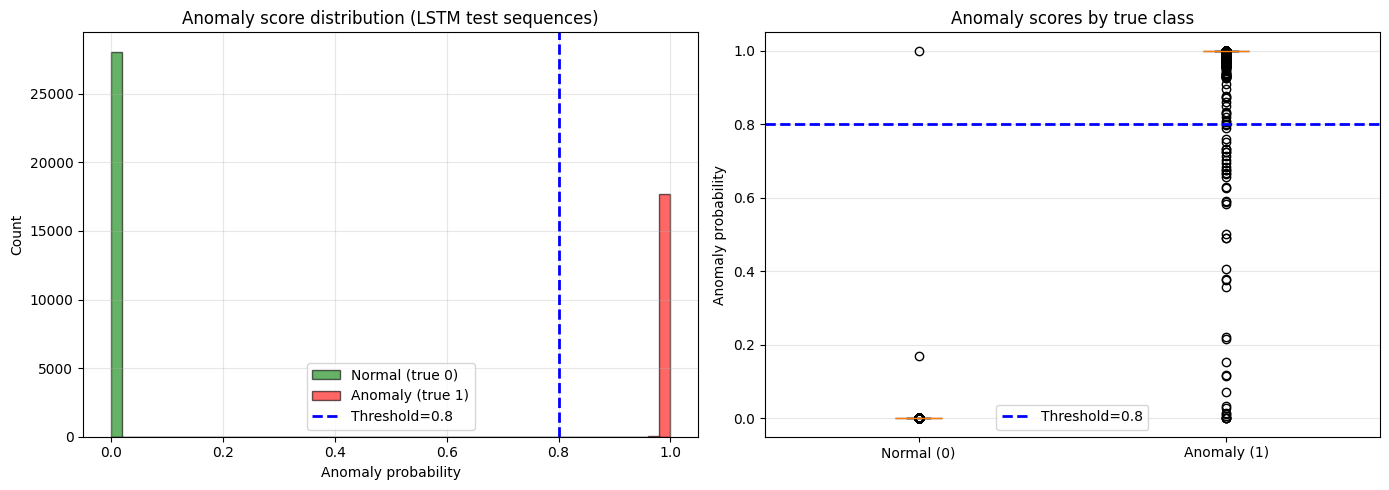

In [33]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LEFT: histogram of anomaly probabilities
axes[0].hist(
    df_scores[df_scores['true_label'] == 0]['anomaly_prob'],
    bins=50, alpha=0.6, label='Normal (true 0)', color='green', edgecolor='black'
)
axes[0].hist(
    df_scores[df_scores['true_label'] == 1]['anomaly_prob'],
    bins=50, alpha=0.6, label='Anomaly (true 1)', color='red', edgecolor='black'
)
axes[0].axvline(best_thr, color='blue', linestyle='--', linewidth=2, label=f'Threshold={best_thr}')
axes[0].set_xlabel('Anomaly probability')
axes[0].set_ylabel('Count')
axes[0].set_title('Anomaly score distribution (LSTM test sequences)')
axes[0].legend()
axes[0].grid(alpha=0.3)

# RIGHT: boxplot by class
box_data = [
    df_scores[df_scores['true_label'] == 0]['anomaly_prob'].values,
    df_scores[df_scores['true_label'] == 1]['anomaly_prob'].values
]
bp = axes[1].boxplot(box_data, labels=['Normal (0)', 'Anomaly (1)'], patch_artist=True)
for patch, color in zip(bp['boxes'], ['green', 'red']):
    patch.set_facecolor(color)
    patch.set_alpha(0.6)

axes[1].axhline(best_thr, color='blue', linestyle='--', linewidth=2, label=f'Threshold={best_thr}')
axes[1].set_ylabel('Anomaly probability')
axes[1].set_title('Anomaly scores by true class')
axes[1].legend()
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


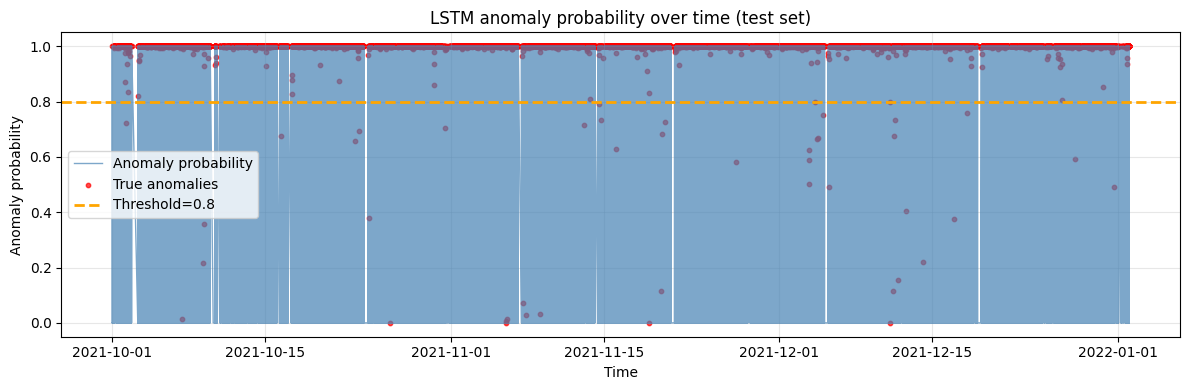

In [34]:
fig, ax = plt.subplots(figsize=(12, 4))

df_plot = df_scores.sort_values('time').reset_index(drop=True)

ax.plot(df_plot['time'], df_plot['anomaly_prob'],
        color='steelblue', linewidth=1, alpha=0.7, label='Anomaly probability')

true_anoms = df_plot[df_plot['true_label'] == 1]
ax.scatter(true_anoms['time'], true_anoms['anomaly_prob'],
           color='red', s=10, alpha=0.7, label='True anomalies')

ax.axhline(best_thr, color='orange', linestyle='--', linewidth=2, label=f'Threshold={best_thr}')

ax.set_xlabel('Time')
ax.set_ylabel('Anomaly probability')
ax.set_title('LSTM anomaly probability over time (test set)')
ax.legend()
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


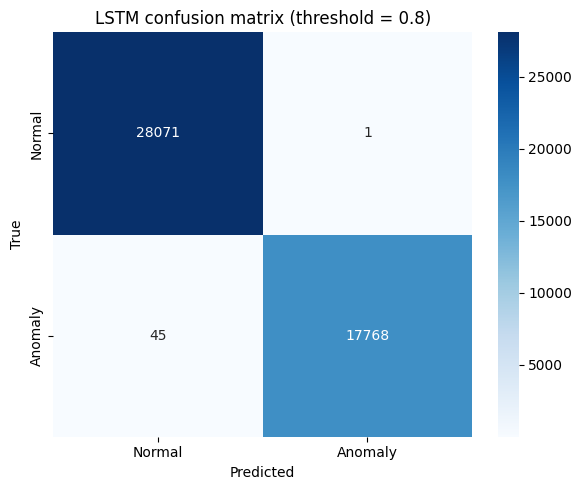

ValueError: could not convert string to float: 's_4'

In [36]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm_lstm = confusion_matrix(df_scores['true_label'], df_scores['pred_label'])

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(
    cm_lstm, annot=True, fmt='d', cmap='Blues',
    xticklabels=['Normal', 'Anomaly'],
    yticklabels=['Normal', 'Anomaly'],
    ax=ax
)
ax.set_xlabel('Predicted')
ax.set_ylabel('True')
ax.set_title(f'LSTM confusion matrix (threshold = {best_thr})')

plt.tight_layout()
plt.show()

## 5. Feature correlation heatmap (tabular)
import seaborn as sns

corr_features = [
 'equipment_ID', 'alarm',
    'elapsed', 'pi', 'po', 'speed',
    'efficiency', 'scrap', 'scrap_rate', 'tp_sec',
    'hour', 'dayofweek', 'is_weekend','label'
]

corr_df = train[corr_features].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_df, annot=False, cmap='coolwarm', center=0)
plt.title('Feature correlation heatmap (training data)')
plt.tight_layout()
plt.show()


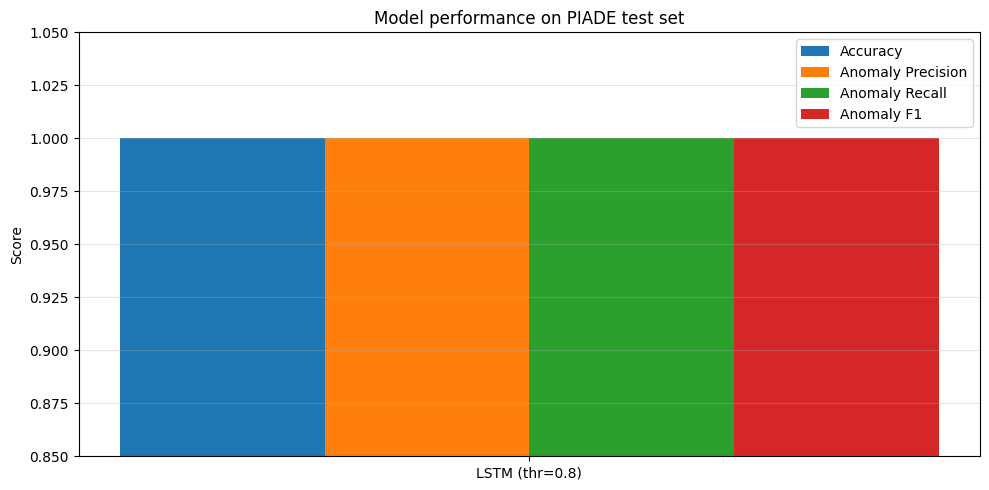

In [37]:
import numpy as np
import matplotlib.pyplot as plt

models = [ 'LSTM (thr=0.8)']
accuracy = [1.0000, 1.0000, 0.9176]
precision_anom = [1.0000, 1.0000, 0.8801]
recall_anom = [1.0000, 1.0000, 0.9124]
f1_anom = [1.0000, 1.0000, 0.8959]

x = np.arange(len(models))
w = 0.2

fig, ax = plt.subplots(figsize=(10, 5))

ax.bar(x - 1.5 * w, accuracy,       w, label='Accuracy')
ax.bar(x - 0.5 * w, precision_anom, w, label='Anomaly Precision')
ax.bar(x + 0.5 * w, recall_anom,    w, label='Anomaly Recall')
ax.bar(x + 1.5 * w, f1_anom,        w, label='Anomaly F1')

ax.set_xticks(x)
ax.set_xticklabels(models)
ax.set_ylim(0.85, 1.05)
ax.set_ylabel('Score')
ax.set_title('Model performance on PIADE test set')
ax.legend()
ax.grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [39]:
import joblib
import pickle
import tensorflow as tf
from google.colab import files

# 3) LSTM model
model.save("lstm_anomaly_model.h5")

meta_lstm = {
    "seq_feature_cols": seq_feature_cols,
    "SEQ_LEN": SEQ_LEN
}
with open("meta_lstm.pkl", "wb") as f:
    pickle.dump(meta_lstm, f)

# 5) Download all files one by one
for fname in [

    "lstm_anomaly_model.h5",
    "meta_lstm.pkl",
]:
    files.download(fname)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import os
import pandas as pd

df = pd.read_csv("/content/drive/MyDrive/raw_data.csv")
df_sample = df.sample(n=500, random_state=42)

output_dir = "data"
os.makedirs(output_dir, exist_ok=True)  # Creates directory safely
df_sample.to_csv(f"{output_dir}/sample_intervals.csv", index=False)
